In [121]:
import requests
from lxml import etree
import time
import csv
import re
import math
import copy

In [3]:
'''
方法名称：get_urls
功能： 生成所有所有的url并存放到迭代器中
参数： num:需要爬取多少页网页
返回值：url:返回一个url的迭代
'''    
def get_urls(number):
    if(type(number) == int and number > 0): #检查输入合法性
        for page in range(1, number + 1):
            url = 'https://sh.lianjia.com/ershoufang/pg' + str(page)
            yield url
    else:
        print('输入不合法')

In [4]:
'''
方法名称：spider
功能： 爬取目标网站，并以源码文本
参数： url：目标网址
'''
def spider(url):
    try:
        #为了避免网站反爬，发送请求的时候携带请求头（也可以多个请求随即切换user_agent）
        #伪装成浏览器 header是浏览器向服务器发送的一个头信息,这里用的是我的浏览器的
        header = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                     AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'}
         
        response = requests.get(url=url, headers=header)
        return response.text
    except:
        print('爬取失败')


In [5]:
text1=spider('https://sh.lianjia.com/ershoufang/pg2')

'<!DOCTYPE html><html><head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge" /><meta http-equiv="Cache-Control" content="no-transform" /><meta http-equiv="Cache-Control" content="no-siteapp" /><meta http-equiv="Content-language" content="zh-CN" /><meta name="format-detection" content="telephone=no" /><meta name="applicable-device" content="pc"><meta name="location" content="province=上海;city=上海;coord=31.2368,121.4804" /><link rel="alternate" media="only screen and (max-width: 640px)" href="https://m.lianjia.com/sh/ershoufang/pg2/" >\n<meta name="mobile-agent" content="format=html5;url=https://m.lianjia.com/sh/ershoufang/pg2/"><script>\nljConf = {\n    city_id: \'310000\',\n    city_abbr: \'sh\',\n    city_name: \'上海\',\n    channel: \'ershoufang\',\n    page: \'ershoufang_search\',\n    pageConfig: {"ajaxroot":"https:\\/\\/ajax.api.lianjia.com\\/","imAppid":"LIANJIA_WEB_20160624","imAppkey":"6dfdcee27d78b1107fceeca55
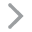
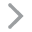

In [6]:
text1

In [7]:
test1X = etree.HTML(text1)

In [8]:
#把我们通过观察网页得到的有规律的Xpath输进去 尾部加上text以显示文本
house_inf1=test1X.xpath('//*[@id="content"]/div[1]/ul/li[1]/div[1]/div[3]/div/text()')[0].strip()

In [15]:
'''
 方法名称：xpath_text
 功能：解析网页源码，提取房屋信息
 参数：url:目标网址
 '''
def xpath_text(url):
    response_text = spider(url)
    #etree.HTML对HTML文本进行初始化，构造XPath解析对象
    house = etree.HTML(response_text)
    for num in range(1, 31):
        #地址1
        house_loc1 = house.xpath('//*[@id="content"]/div[1]/ul/li[%d]/div[1]/div[2]/div/a[1]/text()'
                                 %num)[0].strip()
        #地址2
        house_loc2 = house.xpath('//*[@id="content"]/div[1]/ul/li[%d]/div[1]/div[2]/div/a[2]/text()'
                                 %num)[0].strip()
        #信息
        house_inf = house.xpath('//*[@id="content"]/div[1]/ul/li[%d]/div[1]/div[3]/div/text()'
                                 %num)[0].strip()
        #价格
        house_price = house.xpath('//*[@id="content"]/div[1]/ul/li[%d]/div[1]/div[6]/div[1]/span/text()'
                               %num)[0].strip()
                                 
        #把内容分割
        house_list=house_inf.split('|')
        if len(house_list)!=7:
            continue
        
        #几室
        house_room=eval(house_list[0][0].strip())
        #几厅
        house_hall=eval(house_list[0][2].strip())
        #面积
        house_area=eval(house_list[1][:-3].strip())
        #朝向(把中间空格去掉)
        house_direc=(house_list[2].strip()).replace(' ','')
        #装修
        house_decor=house_list[3].strip()
        #楼层(这边低楼层就取全部楼层的1/4 中楼层就取全部楼层的1/2 高楼层就取全部楼层的3/4)
        if (house_list[4].strip())[0]=='低':
            house_floor=round(eval(re.findall('\d+',house_list[4])[0])/4)
        elif (house_list[4].strip())[0]=='中':
            house_floor=round(eval(re.findall('\d+',house_list[4])[0])/2)
        elif (house_list[4].strip())[0]=='高':
            house_floor=round((eval(re.findall('\d+',house_list[4])[0])/5)*4)
        
        #年份
        house_year=eval((house_list[5].strip())[:4])
        #什么楼
        house_bui=house_list[6].strip()
        
        
        house_data = [house_loc1, house_loc2, house_room, house_hall, \
                       house_area, house_direc, house_decor, house_floor, house_year,house_bui,house_price]
        save_csv(house_data)
         

In [10]:
'''
方法名称：save_csv
功能： 将数据按行储存到csv文件中
参数： house_data:获取到的房屋数据列表
'''   
def save_csv(house_data):
    try:
        with open('C:/Users/yuki/Desktop/爬虫/data.csv', 'a', encoding='gbk', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(house_data)
    except:
        print('write csv error!')

In [ ]:
#写入首列csv
save_csv(['地址1', '地址2', '室', '厅','面积', '朝向', '装修', '楼层', '年份','楼种','价格'])
for url in get_urls(99):
    try:
        time.sleep(10)
        xpath_text(url)
    except:
        print('出错啦!')

## 导入包

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
import random
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## 导入数据

In [22]:
df_all=pd.read_csv('C:/Users/yuki/Desktop/爬虫/data.csv',encoding='gbk')

## 查看数据情况

In [23]:
df_all

,序号,地址1,地址2,室,厅,面积,朝向,装修,楼层,年份,楼种,价格
0,1,欣梅苑,宣桥,1,1,54.59,南,精装,3,2007,板楼,133.0
1,2,象屿上海年华,莘闵别墅,2,2,82.34,南北,精装,4,2016,板楼,308.0
2,3,同润菲诗艾伦,泗泾,3,1,88.65,南,精装,5,2010,板楼,315.0
3,4,阳城贵都,阳城,2,2,96.94,南,简装,6,2010,板楼,710.0
4,5,桃浦六村绿春苑,桃浦,2,1,57.05,南北,简装,5,1994,板楼,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595,2596,紫东新苑,松江新城,2,2,83.94,南,精装,5,2005,板楼,300.0
2596,2597,明和苑,五角场,3,2,135.42,南,简装,10,2003,板楼,1080.0
2597,2598,新申花城茉莉苑,莘庄,2,1,72.38,南,简装,2,1997,板楼,533.0
2598,2599,宝菊新家园,菊园新区,3,2,136.83,南北,精装,10,2008,板楼,426.0


In [24]:
#查看各字段得信息,因为爬取数据的时候直接把有缺失值得数据删掉了所以所有数据都无缺失值
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   序号      2600 non-null   int64  
 1   地址1     2600 non-null   object 
 2   地址2     2600 non-null   object 
 3   室       2600 non-null   int64  
 4   厅       2600 non-null   int64  
 5   面积      2600 non-null   float64
 6   朝向      2600 non-null   object 
 7   装修      2600 non-null   object 
 8   楼层      2600 non-null   int64  
 9   年份      2600 non-null   int64  
 10  楼种      2600 non-null   object 
 11  价格      2600 non-null   float64
dtypes: float64(2), int64(5), object(5)
memory usage: 243.9+ KB
None


In [25]:
#取除id和price结果以外的所有数据，重新构成索引
df=df_all.loc[:,'地址1':'楼种']

In [26]:
df

,地址1,地址2,室,厅,面积,朝向,装修,楼层,年份,楼种
0,欣梅苑,宣桥,1,1,54.59,南,精装,3,2007,板楼
1,象屿上海年华,莘闵别墅,2,2,82.34,南北,精装,4,2016,板楼
2,同润菲诗艾伦,泗泾,3,1,88.65,南,精装,5,2010,板楼
3,阳城贵都,阳城,2,2,96.94,南,简装,6,2010,板楼
4,桃浦六村绿春苑,桃浦,2,1,57.05,南北,简装,5,1994,板楼
...,...,...,...,...,...,...,...,...,...,...
2595,紫东新苑,松江新城,2,2,83.94,南,精装,5,2005,板楼
2596,明和苑,五角场,3,2,135.42,南,简装,10,2003,板楼
2597,新申花城茉莉苑,莘庄,2,1,72.38,南,简装,2,1997,板楼
2598,宝菊新家园,菊园新区,3,2,136.83,南北,精装,10,2008,板楼


In [44]:
#观察
print(set(df.loc[:,'朝向']))
print(set(df.loc[:,'装修']))
print(set(df.loc[:,'楼种']))

{'东东南南', '南东南西南', '西', '西南', '南东', '西南西', '东南', '西东', '东东南', '南西南北', '北南西', '南西南', '东南北', '西南东南', '西北南', '东北东北', '南东南东', '东南南西', '东', '南东北', '东东南北', '南西北', '南东南', '西南南', '东西', '南西', '东南南', '北南', '南', '西北', '东北', '暂无数据', '南北', '东南西北', '北'}
{'其他', '简装', '精装', '毛坯'}
{'暂无数据', '平房', '板楼', '板塔结合', '塔楼'}


In [54]:
#发现好像朝向这个数据里面有一些重复的东西，我不是很懂房子我感觉是不是南北朝向和北南都一样，所以我把重复的字符都去掉然后重新组起来
for index in range(df.shape[0]):
    df.loc[index,'朝向']=''.join(set(df.loc[index,'朝向']))

In [55]:
print(set(df.loc[:,'朝向']))

{'西北', '西', '西北南东', '西北南', '暂无数据', '西南', '南东', '西东', '北东', '东', '东西南', '东南', '西南东', '北南东', '北', '北南', '东北南', '南'}


In [56]:
#统计不同类型的特征
object_=[f for f in df.columns if df.dtypes[f]=='object']
not_object_=[f for f in df.columns if df.dtypes[f]!='object']

In [57]:
#把分类变量都转化为字符型的数值变量，先把object类型的都提出来
ob_df=df[object_]
#序列化
#sklearn也提供了序列化工具 – sklearn.preprocessing.LabelEncoder
le = LabelEncoder()
for col in ob_df.columns:    #为每一列序列化,就是将每种字符串转化为对应的数字。用数字代表类别
    ob_df[col] = le.fit_transform(ob_df[col])
ob_df

<ipython-input-57-13edd102bd21>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_df[col] = le.fit_transform(ob_df[col])


,地址1,地址2,朝向,装修,楼种
0,1026,55,8,3,4
1,1520,123,6,3,4
2,459,98,8,3,4
3,1704,146,8,2,4
4,986,89,6,2,4
...,...,...,...,...,...
2595,1301,87,8,3,4
2596,897,19,8,2,4
2597,866,122,8,2,4
2598,637,124,6,3,4


In [60]:
#因为这个只是类别数据 大小没有关系 所以全部转化为字符型变量
ob_df=ob_df.astype(str)

In [62]:
ob_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   地址1     2600 non-null   object
 1   地址2     2600 non-null   object
 2   朝向      2600 non-null   object
 3   装修      2600 non-null   object
 4   楼种      2600 non-null   object
dtypes: object(5)
memory usage: 101.7+ KB


In [63]:
#把数据再合在一起
df_after=pd.concat((ob_df,df[not_object_]),axis=1)

In [64]:
df_after

,地址1,地址2,朝向,装修,楼种,室,厅,面积,楼层,年份
0,1026,55,8,3,4,1,1,54.59,3,2007
1,1520,123,6,3,4,2,2,82.34,4,2016
2,459,98,8,3,4,3,1,88.65,5,2010
3,1704,146,8,2,4,2,2,96.94,6,2010
4,986,89,6,2,4,2,1,57.05,5,1994
...,...,...,...,...,...,...,...,...,...,...
2595,1301,87,8,3,4,2,2,83.94,5,2005
2596,897,19,8,2,4,3,2,135.42,10,2003
2597,866,122,8,2,4,2,1,72.38,2,1997
2598,637,124,6,3,4,3,2,136.83,10,2008


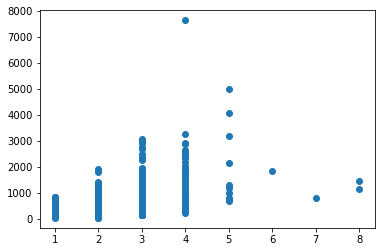

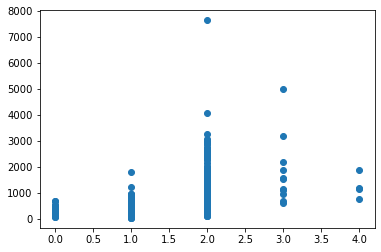

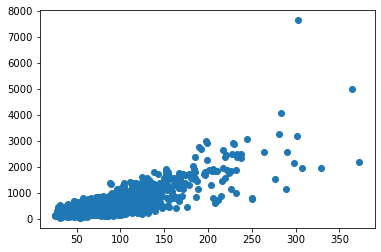

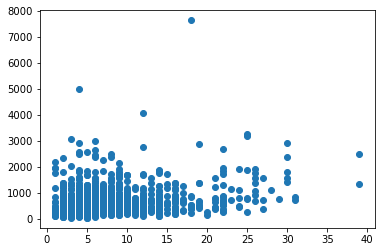

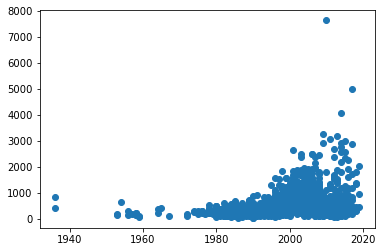

In [68]:
#查看特征与price之间的关系
for f in not_object_:
        plt.scatter(x=df_after[f],y=df_all['价格'])
        plt.show()

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 22336 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-pack

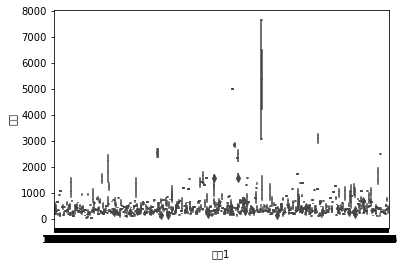

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 22320 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 22336 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-pack

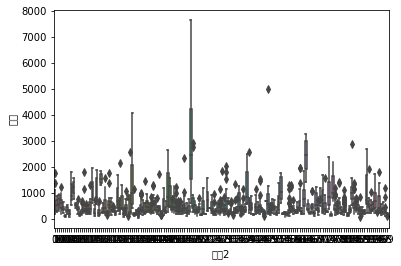

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26397 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-pack

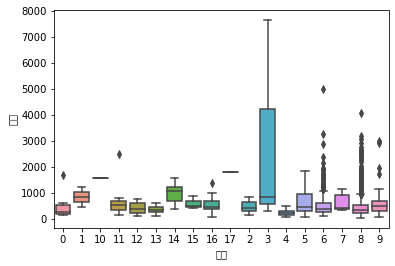

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 35013 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 35013 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20462 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-pack

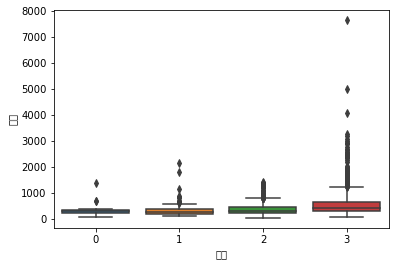

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 27004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 31181 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 27004 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 31181 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-pack

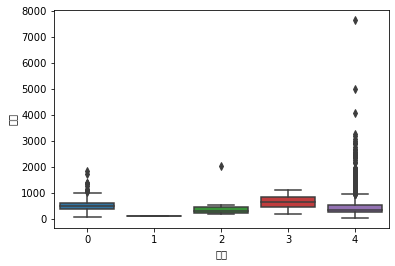

In [70]:
#查看特征与price之间的关系
for f in object_:
        fig=sns.boxplot(df_after[f],df_all['价格'])
        plt.show()

### 处理异常值

Text(0, 0.5, 'price')

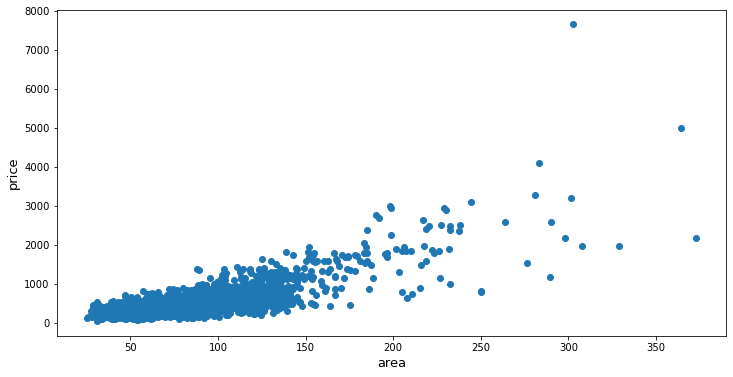

In [71]:
plt.figure(figsize=(12,6))
plt.scatter(x=df_after.面积,y=df_all.价格)
plt.xlabel('area',fontsize=13)
plt.ylabel('price',fontsize=13)

In [76]:
drop_index=df_all[df_all['价格']>7000].index
print(drop_index)
#不是一般的豪华，因为除了实际室内300平以外还有200平的大露台
#所以如果房价需要更精确预测还需要对每个房源里的一些介绍进行爬取
#这次以防影响预测就先删掉

Int64Index([373], dtype='int64')


In [80]:
#删除异常点
df_all.drop(drop_index,inplace=True)
df_after.drop(drop_index,inplace=True)

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0, flags=flags)


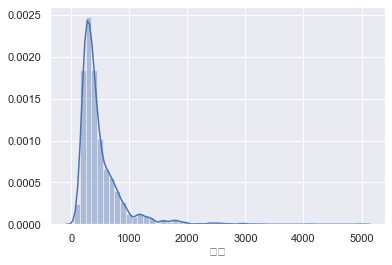

19.930213398343465
3.508507785537859


In [92]:
sns.set(font_scale=1)
#观察价格的峰度
sns.distplot(df_all['价格'])
plt.show()

#计算峰度和偏度
print(ss.kurtosis(df_all['价格']))
print(ss.skew(df_all['价格']))

分布偏右，比较陡峭

In [96]:
#对价格做平滑/正态化处理，便于分类器的学习
price=np.log1p(df_all['价格'])

In [97]:
price

0       4.897840
1       5.733341
2       5.755742
3       6.566672
4       5.283204
          ...   
2595    5.707110
2596    6.985642
2597    6.280396
2598    6.056784
2599    5.981414
Name: 价格, Length: 2599, dtype: float64

D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0, flags=flags)


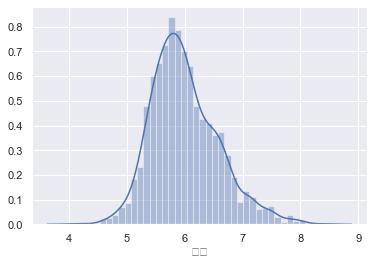

In [98]:
sns.distplot(price)
plt.show()

In [111]:
#将所有category数据进行OneHot
dummy_df = pd.get_dummies(df_after)

In [112]:
dummy_df

,室,厅,面积,楼层,年份,地址1_0,地址1_1,地址1_10,地址1_100,地址1_1000,...,朝向_9,装修_0,装修_1,装修_2,装修_3,楼种_0,楼种_1,楼种_2,楼种_3,楼种_4
0,1,1,54.59,3,2007,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2,2,82.34,4,2016,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,3,1,88.65,5,2010,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,2,2,96.94,6,2010,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,1,57.05,5,1994,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,2,2,83.94,5,2005,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2596,3,2,135.42,10,2003,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2597,2,1,72.38,2,1997,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2598,3,2,136.83,10,2008,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [123]:
#观察选择出来的特征是否有非数值型数据，对数值型数据进行标准化
cols=df_after.columns[df_after.dtypes!='object']

#标准化数据 (X-mean(X))/std
cols_means=dummy_df.loc[:,cols].mean()
cols_std=dummy_df.loc[:,cols].std()

numeric_df=copy.deepcopy(dummy_df)
numeric_df.loc[:,cols]=(dummy_df.loc[:,cols]-cols_means)/cols_std

In [124]:
numeric_df

,室,厅,面积,楼层,年份,地址1_0,地址1_1,地址1_10,地址1_100,地址1_1000,...,朝向_9,装修_0,装修_1,装修_2,装修_3,楼种_0,楼种_1,楼种_2,楼种_3,楼种_4
0,-1.393164,-0.684509,-0.726092,-0.603333,0.688970,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,-0.112813,1.026106,0.012902,-0.379930,1.586430,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1.167539,-0.684509,0.180940,-0.156528,0.988123,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,-0.112813,1.026106,0.401706,0.066875,0.988123,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,-0.112813,-0.684509,-0.660581,-0.156528,-0.607362,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,-0.112813,1.026106,0.055511,-0.156528,0.489534,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2596,1.167539,1.026106,1.426445,0.960484,0.290099,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2597,-0.112813,-0.684509,-0.252337,-0.826735,-0.308208,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2598,1.167539,1.026106,1.463994,0.960484,0.788688,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [125]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
#随机划分训练集和测试集。
#test_size表明测试集占整体样本的比例；random_state是随机数种子，当为0时，每次生成的随机数即随机顺序是不相同的，当为固定的数值时，可以在多次运行时获得相同的随机数。
x_train,x_test,y_train,y_test=train_test_split(numeric_df,price,test_size=0.3,random_state=40)

In [126]:
y_train

2274    5.420535
381     6.463029
103     5.874931
868     6.212606
382     6.722630
          ...   
1864    5.351858
1331    6.311735
2214    6.030685
2056    6.236370
2268    5.877736
Name: 价格, Length: 1819, dtype: float64

In [127]:
x_train.shape,x_test.shape

((1819, 1996), (780, 1996))

## 模型预测

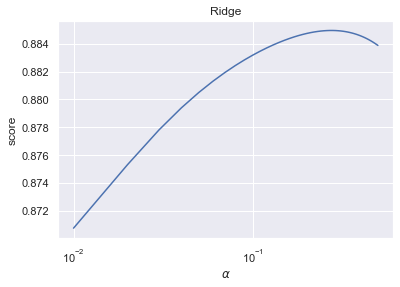

In [183]:
#选用Ridge Regression模型观察效果
from sklearn.linear_model import Ridge
#测试不同的α值对预测性能的影响
def test_ridge_alpha(X_train, X_test, y_train, y_test):
    alphas = np.linspace(0.01,0.5,50)
    scores = []
    #enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标。
    for i, alpha in enumerate(alphas):
        #代入不同的参数进行建模得到的分
        ridgeRegression = Ridge(alpha=alpha)
        ridgeRegression.fit(X_train, y_train)
        scores.append(ridgeRegression.score(X_test, y_test))
    return alphas, scores

def show_plot(alphas, scores):
    figure = plt.figure()
    ax = figure.add_subplot(1, 1, 1)
    ax.plot(alphas, scores)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"score")
    ax.set_xscale("log")
    ax.set_title("Ridge")
    plt.show()

alphas,scores=test_ridge_alpha(x_train, x_test, y_train, y_test)
show_plot(alphas,scores)

In [192]:
alphas[scores.index(max(scores))]

0.28

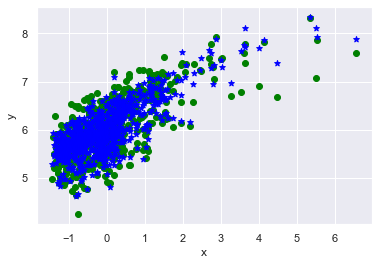

In [193]:
# 使用模型预测
model=Ridge(alpha=0.28)
model.fit(x_train,y_train)
y_predicted = model.predict(x_test)
plt.scatter(x_test.面积, y_test, marker='o',color='green',label='原始数据')

# 绘制散点图 参数：x横轴 y纵轴
plt.scatter(x_test.面积, y_predicted, marker='*',color='blue',label='测试数据')

# 绘制x轴和y轴坐标
plt.xlabel("x")
plt.ylabel("y")

# 显示图形
plt.show()

In [194]:
print(model.score(x_train,y_train))
print(model.score(x_test, y_test))

0.9917862202421787
0.8849583096474116


In [195]:
#y_pre=np.expm1(y_predicted)
pre={'true':y_test,'pre':y_predicted}
house_pre=pd.DataFrame(pre)

In [196]:
house_pre

,true,pre
2162,5.545177,5.561043
1940,5.420535,5.361187
1995,5.726848,5.689785
1922,6.444131,6.497534
626,5.768321,5.526196
...,...,...
339,6.907755,6.612182
1198,5.693732,5.825896
1098,5.433722,5.378334
1073,5.545177,5.880748


In [197]:
#使用多元线性回归
#因为所有特征都做了标准化处理，所以不会出现特征值大小相差过多的情况，可以直接进行

#定义线性模型，输入和模型的参数θ相乘得到预测的结果
def net(X,theta):
    return np.dot(X,theta.T)

#定义损失函数，平方误差
def costFunc(h,y):
    cost=np.power((h-y),2)
    return np.sum(cost)/(len(y)*2)

#定义梯度下降模型
def gradientDes(X,y,theta,alpha,iters):
    #取一组theta的个数，先降为一维
    thetaNum=int(np.ravel(theta).shape[0])
    #定义theta的中间量供中途储存更新后的theta
    temp=np.zeros(theta.shape)
    #记录损失
    cost=[]
    
    #每次遍历沿着梯度反方向选择最好的数据进行更新
    for i in range(iters):
        #计算此theta的误差
        error=np.dot(X,theta.T)-y
        
        #遍历theta进行更新
        for j in range(thetaNum):
            #计算，error和xi对应位置相乘
            temp[0,j]=theta[0,j]-(alpha/len(X))*np.sum(error*X[:,j].reshape(error.shape))
            
        #更新theta
        theta=temp
        
        #目前预测出来的数值
        h=net(X,theta)
        #目前的损失函数
        loss=costFunc(h,y)
        cost.append(loss)
        
        #每迭代100次输出一次图像和数据
        if (i+1)%100==0:
            print("Epoch %s. Moving loss: %s. "  
                  % (i, loss))
            plot(cost,X,theta)
    
    return theta,cost

#定义绘图函数
def plot(losses, X, theta, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    #这里取每个房子的所有特征值的均值作为画到图上的x
    fg2.plot(X.mean(axis=1)[:sample_size],
             net(X[:sample_size, :], theta), 'or', label='Estimated')
    fg2.plot(X.mean(axis=1)[:sample_size],
             y[:sample_size,:], '*g', label='Real')
    fg2.legend()
    plt.show()#把之前处理好的数据转化成数组的形式，t#把之前处理好的数据转化成数组的形式，train数据前加上常数列

In [198]:
#把之前处理好的数据转化成数组的形式，train数据前加上常数列
X=np.array(x_train)
y=np.array(y_train).reshape(len(np.array(y_train)),1)
X = np.insert(X, 0, values=np.ones(len(X)), axis=1)

Epoch 99. Moving loss: 0.1821601137627397. 


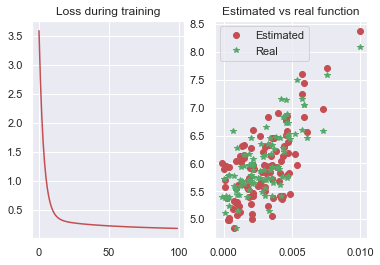

Epoch 199. Moving loss: 0.14640061580183095. 


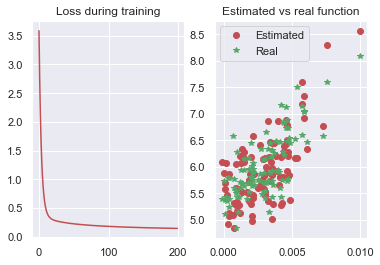

Epoch 299. Moving loss: 0.1306919044028098. 


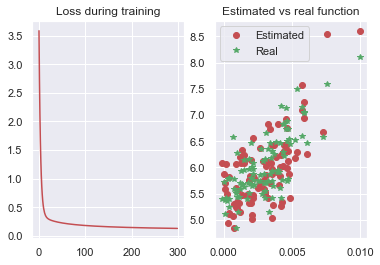

In [210]:
#训练
alpha=0.05
thetaNum=X.shape[1]
theta=np.random.rand(X.shape[1]).reshape(1,X.shape[1])
iters=300
theta,cost=gradientDes(X,y,theta,alpha,iters)

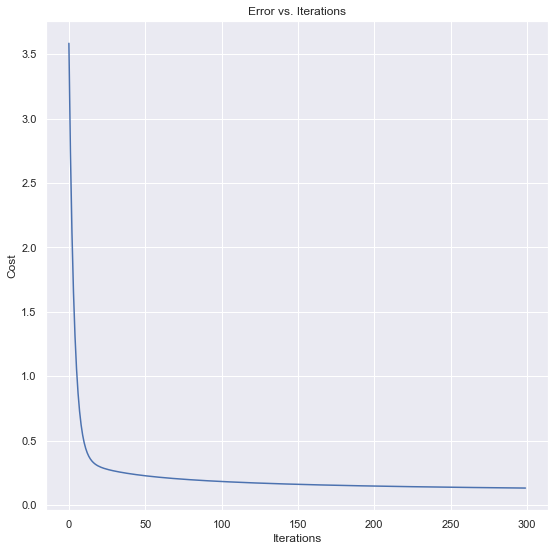

In [211]:
#绘制训练误差图
fig,ax=plt.subplots(figsize=(9,9))
ax.plot(np.arange(iters),cost,'b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Iterations')
plt.show()

In [229]:
X_test=np.array(x_test)
X_test = np.insert(X_test, 0, values=np.ones(len(x_test)), axis=1)
Y_test=np.array(y_test)

#预测出来的数据转化回正态化之前的形式
pre={'True_Pirce':list(np.ravel(Y_test)),
    'Pre_Price':list(np.ravel(net(X_test,theta)))}
housePre=pd.DataFrame(pre)

In [230]:
housePre

,True_Pirce,Pre_Price
0,5.545177,5.654993
1,5.420535,5.662992
2,5.726848,5.595604
3,6.444131,5.818862
4,5.768321,4.822517
...,...,...
775,6.907755,6.826619
776,5.693732,5.764294
777,5.433722,5.527058
778,5.545177,5.420082
